In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from state_space import simulator,system
from state_space.base import InputWarpper,Timer
from state_space.system import Pendulm
from state_space.simulator import DynamicSystem,Variable,WhiteNoise,TimerVariable

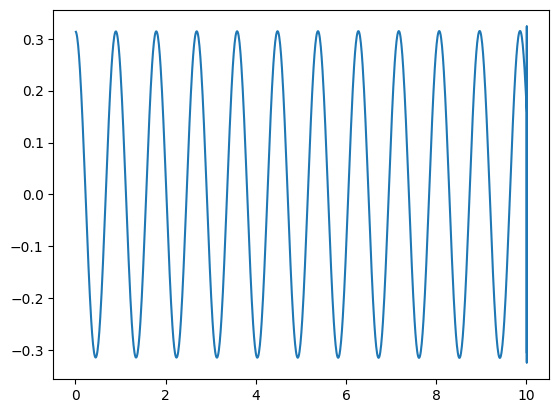

In [2]:
pendulm = Pendulm(1,0.2)
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D,Timer(10))
simulator.init(np.array([[np.pi/10],[0]]))
theta = []
for step in range(10000):
    t = simulator.update(0)
    simulator.timer.update()
    theta.append([simulator.t,t.item()])
    
theta = np.array(theta)
plt.plot(theta[:,0],theta[:,1])
# simulator.u= 0
# simulator.simulate()

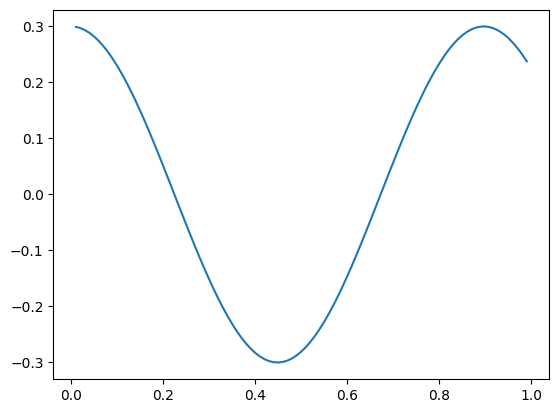

In [3]:
simulator.init(np.array([[0.3],[0]]))
simulator.set_u(0)
simulator.set_t_stop(1)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

[[-0.27689589]]


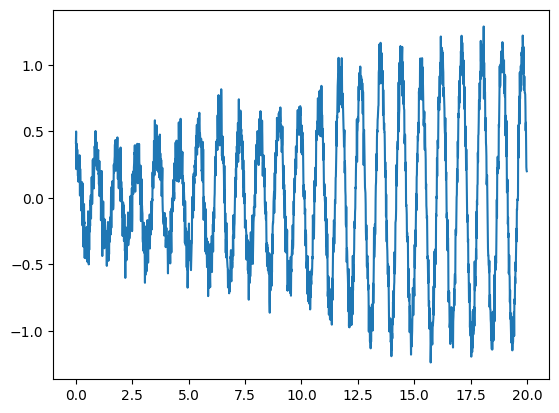

In [4]:
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D)
simulator.init(np.array([[np.pi/10],[0]]))
simulator.set_u(0)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.3)
measure_noise = WhiteNoise(0,0.1)
simulator.u = noise
history = []
for i in simulator:
    history.append([simulator.t,i.item()+measure_noise.y.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
print(simulator.u)

In [6]:

from state_space.kalman_filter import KalmanFilter
from state_space.simulator import DiscreteDynamicSystem
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D)
dis_simulator = DiscreteDynamicSystem.from_continous(simulator,np.array([[np.pi/10],[0]]))
filter = KalmanFilter(dis_simulator._A,dis_simulator._B,dis_simulator._C,dis_simulator._x,np.diag((0,1)))

[[0.01577737]]


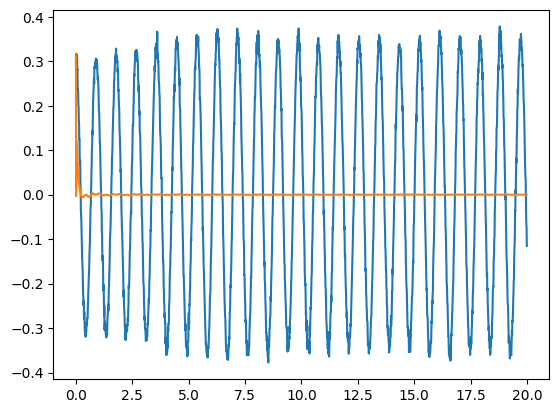

In [7]:
simulator.init(np.array([[np.pi/10],[0]]))
filter.init(simulator.x)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.03)
measure_noise = WhiteNoise(0,0.01)
simulator.u = noise
history = []
for i in simulator:
    y = i.item()+measure_noise.y.item()
    _,pre = filter.predict(simulator.u)
    filter.update(y)
    history.append([simulator.t,y,pre.item()])
    # history.append([simulator.t,y])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
plt.plot(history[:,0],history[:,2])
print(simulator.u)

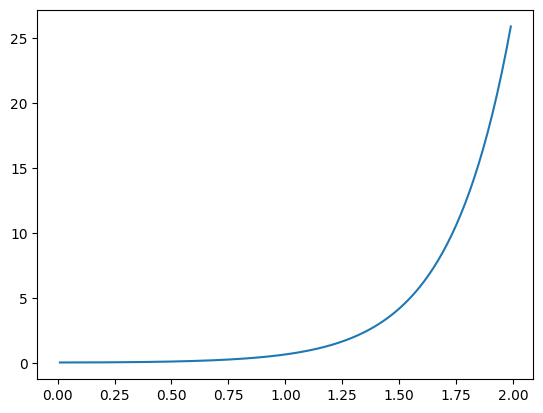

In [8]:
from state_space.system import InvertPendulm
m,M,L = 48,47.7,0.85
simulator = DynamicSystem.from_system(InvertPendulm(m,M,L))
simulator.init(np.array([[0],[0],[np.pi/100],[0]]))
simulator.set_u(0)
simulator.set_t_stop(2)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

In [9]:
from state_space.base import Timer
from state_space.transfer_function import Transfer
timer = Timer(10,0.001)
def cos(t):
    return np.cos(2*np.pi*t)
# s = Variable(0,0.001,10,cos)
s = TimerVariable(timer,cos)
a = Transfer([1],[1,2,14],0,timer)
a.u = s

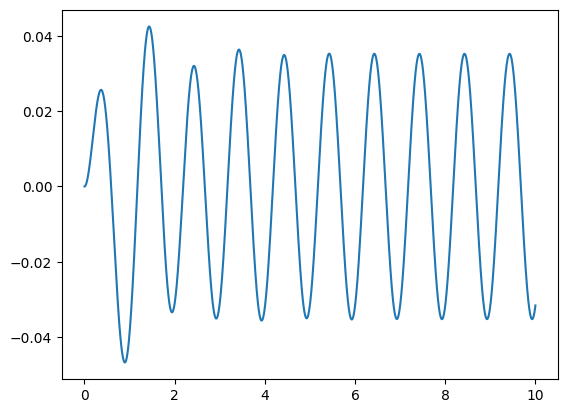

array([[ 1.00000000e-03,  0.00000000e+00],
       [ 2.00000000e-03,  9.98980281e-07],
       [ 3.00000000e-03,  2.99487174e-06],
       ...,
       [ 9.99800000e+00, -3.17618315e-02],
       [ 9.99900000e+00, -3.16658677e-02],
       [ 1.00000000e+01, -3.15686537e-02]])

In [10]:
a.simulate()

In [11]:
from state_space.transfer_function import Serial,FeedBack
f1 = Transfer([1],[1,2,14],0)
f2 = Transfer([1],[4,1],0)
f = Serial(f1,f2)
f1.u = 1
f2.u = 1
f.u = 1

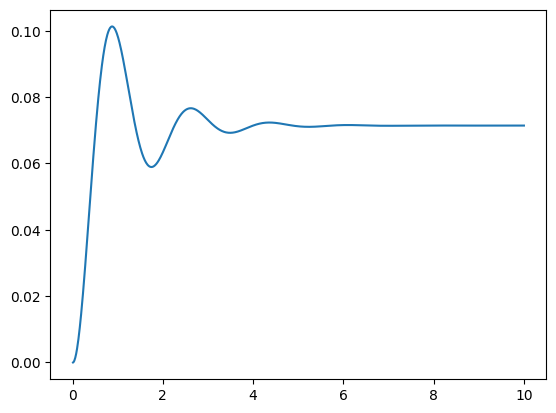

In [12]:
f1.u = 1
_ = f1.simulate()

In [13]:
def sigma(y):
    t = 0.02
    if y<t and y> -t:
        return 1/t
    else:
        return 0

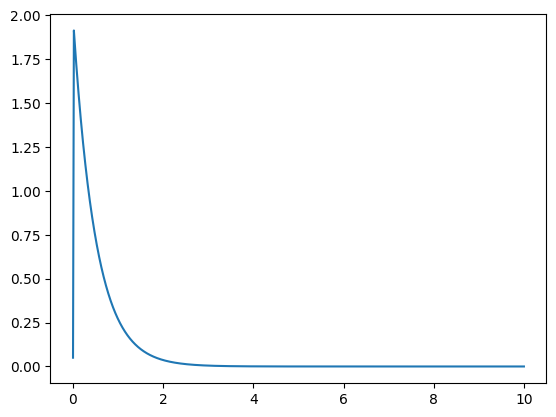

(0.4970000000000004, 1.9134209403483358)

In [14]:
T = 0.5
timer=Timer(10,0.0005)
u = TimerVariable(timer,sigma)
f2 = Transfer((1,),(T,1),timer=timer)
f2.init(np.array([[0]]))
f2.u = u
y = f2.simulate()
#estimate T base on output
y[np.where(y[:,1]>(1/(T*np.e)))[0][-1],0],np.max(y[:,1])

0.4995000000000004

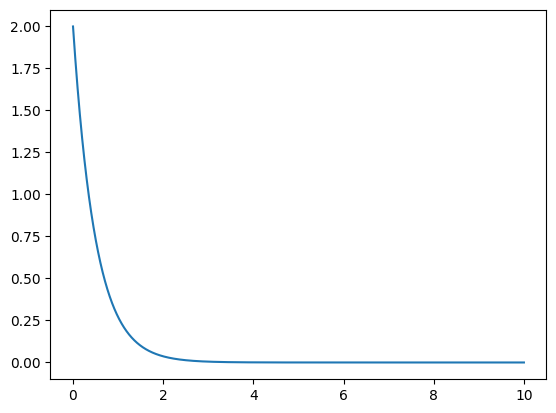

In [15]:
x = 1/T*np.exp(-y[:,0]/T)
plt.plot(y[:,0],x)
y[np.where(x>(1/(T*np.e)))[0][-1],0]

## Concat in System Map

In [21]:
from state_space.system_map import Concat,BaseBlock
timer = Timer()
t1 = Transfer((1,),(2,1),timer=timer)
t2 = Transfer((1,),(1,2,1),timer=timer)
t1.u,t2.u = 1,1
con = Concat([t1,t2],(1,-1))

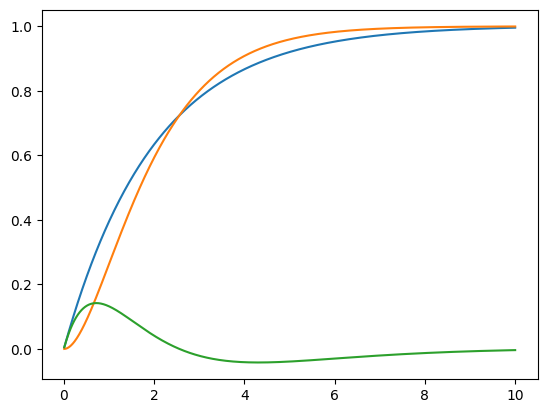

In [22]:
h = []
t1.init(np.array([[0]]))
t2.init(np.array([[0],[0]]))
for t in timer:
    y1 = t1.update_self()
    y2 = t2.update_self()
    h.append([t,y1.item(),y2.item(),con.y.item()])
h = np.array(h)
plt.plot(h[:,0],h[:,1])
plt.plot(h[:,0],h[:,2])
plt.plot(h[:,0],h[:,3])